# **ME 193, Spring 2021**
## Final Project Notebook 


**Notes**:

1. 

In [8]:
import os
import numpy as np
import pandas as pd
import requests
from IPython.display import JSON

import sklearn.tree as tree
import sklearn.metrics as mt
import sklearn.ensemble as ens
import matplotlib.pyplot as plt
import sklearn.model_selection

import seaborn as sns
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

## Import data
Scrape vivino website by analyzing Network tab on the all search and pulling API request info. id = 1 is red wines and id = 2 is whites. Parems for search included
Red network url: https://www.vivino.com/api/explore/explore?country_code=US&currency_code=USD&grape_filter=varietal&min_rating=1&order_by=ratings_average&order=desc&page=1&price_range_max=500&price_range_min=0&wine_type_ids[]=1

In [50]:
url = "https://www.vivino.com/api/explore/explore"
headers= {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
#page_num = 1
matches = []

for i, page_num in enumerate(range(1, 6)):
    r = requests.get(url,
        params = {
            "country_code": "US",
            "currency_code":"USD",
            "grape_filter":"varietal",
            "min_rating":"1",
            "order_by":"ratings_average",
            "order":"desc",
            "page": page_num,
            "price_range_max":"450",
            "price_range_min":"0",
            "wine_type_ids[]":"1"
        }, headers=headers)
    print(page_num, end='\r')
    reds = r.json()
    matches.extend(reds["explore_vintage"]["matches"])

results = [
    (
        t["vintage"]["wine"]["winery"]["name"], 
        #f'{t["vintage"]["wine"]["name"]} {t["vintage"]["year"]}',
        t["vintage"]["wine"]["name"],
        t["price"]["amount"],
        t["vintage"]["year"],
        t["vintage"]["wine"]["style"]["varietal_name"],
        t["vintage"]["wine"]["region"]["name"],
        t["vintage"]["wine"]["region"]["country"]["name"],
        t["vintage"]["statistics"]["ratings_average"],
        t["vintage"]["wine"]["taste"]["structure"]["acidity"],
        t["vintage"]["wine"]["taste"]["structure"]["sweetness"],
        t["vintage"]["wine"]["taste"]["structure"]["tannin"],
        # flavors
        [j["group"] for j in t["vintage"]["wine"]["taste"]["flavor"]]
    )
    for t in matches
]

df_reds = pd.DataFrame(results,columns=['Winery','Wine','Price','Year','Grape','Region','Country','Rating','Acidity','Sweetness','Tannin','Flavor'])
print(page_num)
print(len(df_reds))
df_reds.head()

5
125


,Winery,Wine,Price,Year,Grape,Region,Country,Rating,Acidity,Sweetness,Tannin,Flavor
0,Château Lagrézette,Le Pigeonnier Malbec,186.99,2013,Malbec,Cahors,France,4.8,3.033677,1.683774,3.381870,"[oak, earth, black_fruit, non_oak, spices, mic..."
1,Viña Cobos,Cobos Chañares Estate Malbec,349.99,2016,Malbec,Tunuyán,Argentina,4.8,2.791039,2.112970,2.788464,"[oak, black_fruit, spices, non_oak, floral, ea..."
2,Antinori,Tenuta Tignanello 'Solaia',349.99,2017,Red,Toscana,Italy,4.8,3.077701,1.899224,2.966772,"[oak, earth, black_fruit, non_oak, spices, red..."
3,Frank Family,Patriarch,219.99,2015,Cabernet Sauvignon,Rutherford,United States,4.8,3.327367,1.359278,3.235493,"[oak, earth, non_oak, black_fruit, spices, red..."
4,Realm,Farella Vineyard,239.95,2016,Cabernet Sauvignon,Coombsville,United States,4.8,3.247900,1.583510,3.424210,"[oak, earth, non_oak, black_fruit, spices, red..."


In [38]:
# display data
#JSON(matches)
#df_reds.head(30)

In [26]:
# Define Function to calculate Within Cluster Variance
def withinClusVar(X,centers,labels,labelset):
    variance = []
    for i in labelset:
        variance.append(np.linalg.norm(X[labels==i]-centers[i])**2/len(X[labels==i]))
    return sum(variance)

Text(0, 0.5, 'WCV')

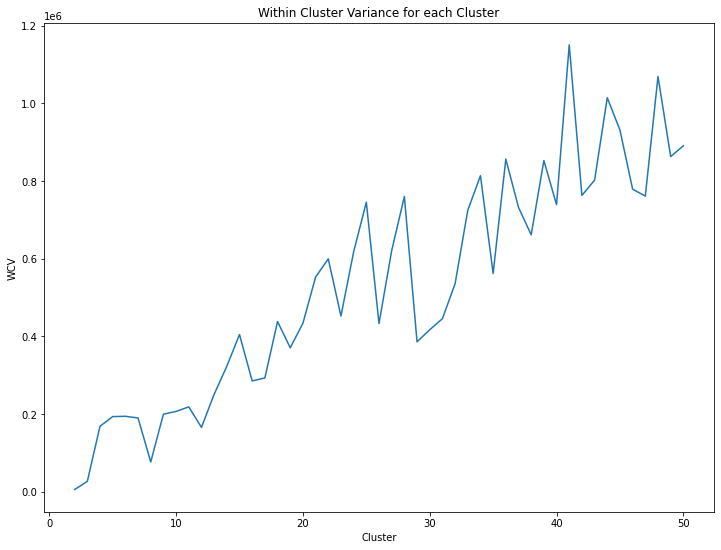

In [27]:
X_test_wine = df_reds.drop(['Winery', 'Wine', 'Grape', 'Region', 'Country', 'Flavor'], axis=1)
n_clusters = np.linspace(2,50,49, dtype='int')
withinClusterVar = []
    

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init = 10, max_iter=200).fit(X_test_wine)
    centers = kmeans.cluster_centers_
    labels = kmeans.fit_predict(X_test_wine)
    labelset = np.unique(labels)
    
    withinClusterVar.append(withinClusVar(X_test_wine, centers, labels, labelset))

plt.figure(figsize = (12,9)) 
plt.plot(n_clusters, withinClusterVar)
plt.title('Within Cluster Variance for each Cluster')
plt.xlabel('Cluster')
plt.ylabel('WCV')

In [29]:
minWCV = min(withinClusterVar)
indexWCV = withinClusterVar.index(minWCV)
minCluster = n_clusters[indexWCV]
print("The K Value that minimizes the Within Cluster Variance is: K =",minCluster)


The K Value that minimizes the Within Cluster Variance is: K = 2


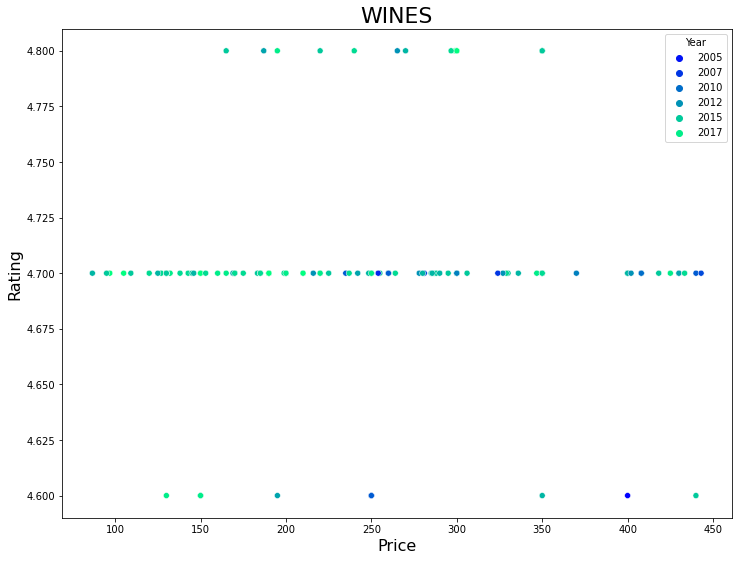

In [35]:
kmeans = KMeans(n_clusters = 2, n_init = 10, max_iter = 300).fit(X_test_wine)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize = (12,9)) 
sns.scatterplot(data=df_reds, x="Price", y="Rating", hue="Year", marker = 'o', legend = 'auto', palette = 'winter')
plt.xlabel('Price', fontsize = '16')
plt.ylabel('Rating',fontsize = '16')
plt.title('WINES', fontsize = '22');